In [32]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import math
from scipy import signal

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer, BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.generalized_gates.mcmt import MCMT
from qiskit.circuit.library.standard_gates.x import XGate, HGate
from qiskit.circuit.library import ZGate
from qiskit.visualization import plot_histogram

In [3]:
def AndOracle(nn):
    
    ''' and-oracle: checks if all input register qubits are |1>
        adapted from: github.com/jianzhi-1/qiskit_advo
    '''
    
    circuit = QuantumCircuit(nn+1) # digit encoded in nn qubits + 1 ancilla qubit + 1 measurement bit
    
    circuit.barrier()    
    # multi control x gate on encoded int with ancilla target
    circuit.mcx(list(range(nn)), nn)
    circuit.barrier()
    
    return circuit

In [4]:
def ControlledOnIntOracle(nn, x):
    
    ''' controlled on int oracle: checks if quantum state (register) represents binary encoded integer x
        adapted from: github.com/jianzhi-1/qiskit_advo
        :param nn ... size of quantum register to encode integer
    '''
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    circuit = QuantumCircuit(nn+1) ## nn qubits for integer encoding + 1 ancilla
    
    circuit.barrier()
    
    # get binary representation
    xx = [int(x) for x in list('{0:0{width}b}'.format(x, width=nn))]

    # flip all binary zeroes in encoded integer
    for n, b in enumerate(xx):
        if b == 0:
            circuit.x(n)
            
    # apply and-oracle
    and_oracle = AndOracle(nn)
    circuit.append(and_oracle, list(range(nn+1)))
    
    # flip all binary ones back
    for n, b in enumerate(xx):
        if b == 0:
            circuit.x(n)
    
    circuit.barrier()
    
    return circuit

# test and-oracle

## build oracle

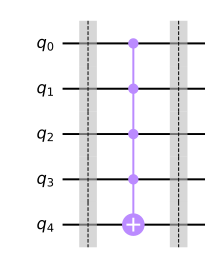

In [5]:
nn = 4 # number of qubits to encode int
and_oracle = AndOracle(nn)
and_oracle.draw(output='mpl')

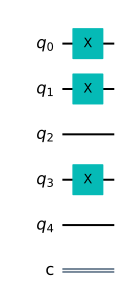

In [6]:
and_test = QuantumCircuit(nn+1,1)
for i in [0,1,3]:
    and_test.x(i)
and_test.draw(output='mpl')

In [7]:
and_test.append(and_oracle, list(range(nn+1)))
and_test.measure(nn,0)

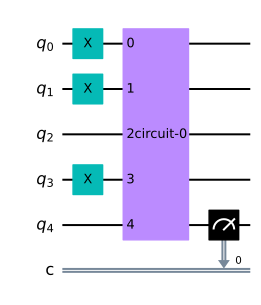

In [8]:
and_test.draw(output='mpl')

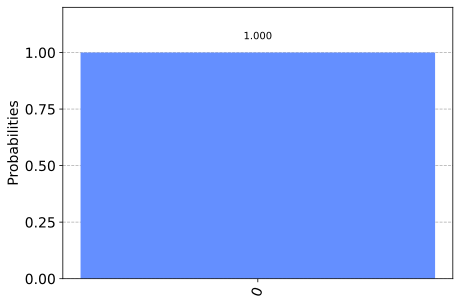

In [9]:
# outputs 1 iff all of the nn qubits are 1, outputs 0 otherwise
simulator = Aer.get_backend('qasm_simulator')
counts = execute(and_test, backend=simulator, shots=1000).result().get_counts(and_test)
plot_histogram(counts)

# test controlled-on-int-oracle

## matching input

In [10]:
control_integer = 5
nn = int(math.floor(math.log2(control_integer) + 1))
control_integer_bin = [int(x) for x in list('{0:0{width}b}'.format(control_integer, width=nn))]

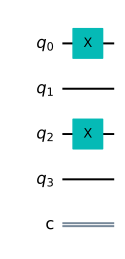

In [11]:
cont_int_test = QuantumCircuit(nn+1, 1) # nn encoding qubits + 1 ancilla + one measurement
# prepare input
for i, v in enumerate(control_integer_bin):
    if v == 1:
        cont_int_test.x(i)
cont_int_test.draw('mpl')

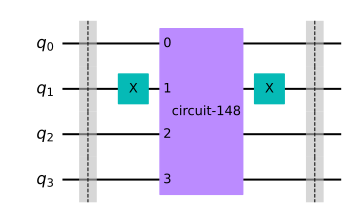

In [12]:
oracle = ControlledOnIntOracle(nn, control_integer)
oracle.draw('mpl')

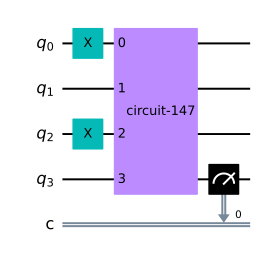

In [13]:
cont_int_test.append(oracle, list(range(nn+1)))
cont_int_test.measure(nn,0)
cont_int_test.draw('mpl')

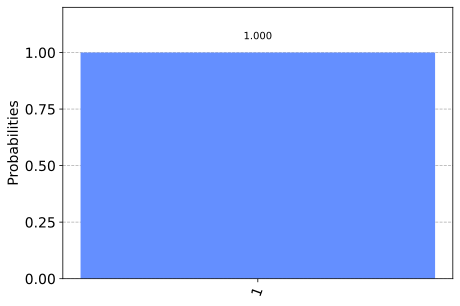

In [14]:
# outputs 1 iff the input is equal to the control integer of the oracle
simulator = Aer.get_backend('qasm_simulator')
counts = execute(cont_int_test, backend=simulator, shots=1000).result().get_counts(cont_int_test)
plot_histogram(counts)

## input not matching oracle

In [15]:
integer = 4
integer_bin = [int(x) for x in list('{0:0{width}b}'.format(integer, width=nn))]

In [16]:
integer_bin

[1, 0, 0]

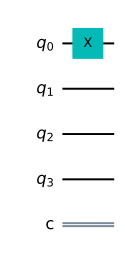

In [17]:
cont_int_test = QuantumCircuit(nn+1, 1) # nn encoding qubits + 1 ancilla + one measurement
# prepare input
for i, v in enumerate(integer_bin):
    if v == 1:
        cont_int_test.x(i)
cont_int_test.draw('mpl')

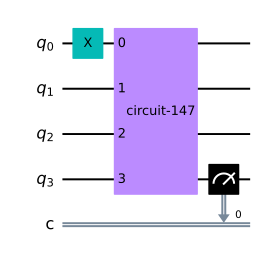

In [18]:
# append oracle constructed to identify value '5'
cont_int_test.append(oracle, list(range(nn+1)))
cont_int_test.measure(nn,0)
cont_int_test.draw('mpl')

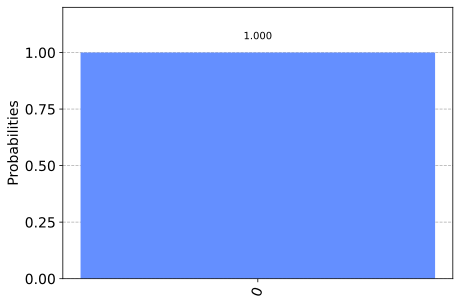

In [19]:
# outputs 1 iff the input is equal to the control integer of the oracle
simulator = Aer.get_backend('qasm_simulator')
counts = execute(cont_int_test, backend=simulator, shots=1000).result().get_counts(cont_int_test)
plot_histogram(counts)

# Linear Composition of winner oracles

In [25]:
cluster_n = 5 # number of clusters determines size of oracles

In [26]:
def create_threshold_oracle_operator(nn, idcs_to_mark):
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**nn)
    # add the -1 phase to marked elements
    for idx in idcs_to_mark:
        oracle_matrix[idx, idx] = -1
        
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    return Operator(oracle_matrix)

In [61]:
def get_indices_to_mark(dist_arr, threshold):
    idx, = np.nonzero(dist_arr < threshold)
    if not idx: # handle minimum element
        idx = np.argmin(distances)
    return idx

In [28]:
def create_threshold_oracle_set(dist_arr):
    
    ''' 
    create linear combination of oracles sum(oracle_t)
    where oracle_t marks all indices i for which f(i) < threshold t
    '''
    
    cluster_n = len(dist_arr)
    nn = int(math.floor(math.log2(cluster_n) + 1))
    oracles = []
    
    for threshold in dist_arr:
        idcs_to_mark = get_indices_to_mark(dist_arr, threshold)
        oracles.append(create_threshold_oracle_operator(nn, idcs_to_mark))
        
    return oracles

In [58]:
def create_oracle_lincombi(threshold, dist_arr, oracles):
    
    '''create linear combi of oracles for a given threshold '''
    
    # create delta-coefficients for linear combi sum_a delta(y - a) * O_a
    idx, = np.where(dist_arr==threshold) # assuming distinct values
    delta_coeff = signal.unit_impulse(len(dist_arr), idx)
    
    oracle_sum = delta_coeff[0] * oracles[0]
    for c, oracle in zip(delta_coeff[1:], oracles[1:]):
        oracle_sum += c * oracle
    
    nn = int(math.floor(math.log2(len(dist_arr)) + 1))
    
    # create a quantum circuit on nn qubits
    qc = QuantumCircuit(nn, name='combi_oracle')
        
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    qc.unitary(oracle_sum, range(nn))
    
    return qc

In [40]:
distances = np.array([17,4,6,2])
nn = int(math.floor(math.log2(len(distances)) + 1))

In [41]:
nn

3

In [44]:
threshold_oracles = create_threshold_oracle_set(distances)

In [60]:
threshold = distances[2] #6
oracle_qc = create_oracle_lincombi(threshold, distances, threshold_oracles)

In [66]:
idcs_to_mark = []
oracle_matrix = np.zeros(2**nn)
oracle_op = Operator(oracle_matrix)
qc_ora = QuantumCircuit(nn)
qc_ora.unitary(oracle_op, range(nn))

ExtensionError: 'Input matrix is not unitary.'

In [67]:
not idcs_to_mark

True

In [68]:
# create a quantum circuit on nn qubits
qc = QuantumCircuit(nn, nn)
for q in range(nn):
    qc.h(q)
# convert oracle_matrix into an operator, and add it to the quantum circuit
qc.append(qc_ora, range(nn))
# step 3: measure all qubits
qc.measure(range(nn), range(nn))